<a href="https://colab.research.google.com/github/marcosw1998/Data-Science/blob/main-igor/Analysis_Notebook/covid_spends_brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise dos custos do governo de Pernambuco - BR em relação à Covid-19**
* Projeto corresponde a entrega parcial para avaliação na cadeira eletiva IF697 - Intro. a Ciência dos Dados
* Autores: Igor Silva e Marcos Cavalcanti
* Conjunto de dados públicos retirados das seguintes fontes:
  * [Portal da Transparência TCU](http://www.portaltransparencia.gov.br/coronavirus)
  * [Prefeitura do Recife](http://dados.recife.pe.gov.br/dataset?tags=sa%C3%BAde)
  * [Brasil.io](https://brasil.io/dataset/covid19/caso_full/)



## **Por quê o tema?**

* Interesse em entender e expor de forma clara os gastos públicos
* Analisar distribuição de gastos
* Covis-19 é um tema importante e merece muita atenção, pois tem feito muitas vítimas e mudado a forma como a sociedade pensa e se organiza
* Entender a distribuição de gastos é uma boa forma de tentar corrigir erros e minimizar danos futuros na economia e na sociedade

## **Carregando as bibliotecas**

  * Utilizaremos a biblioteca ***`Pandas`*** para trabalhar sobre os dados  e a biblioteca ***`Numpy`*** para operações sobre os datasets.
  



In [1]:
import numpy as np
import pandas as pd

Instalação do Pyspark

In [2]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 86kB/s 
     |████████████████████████████████| 204kB 19.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=e1349efd6405ffd65636cfa9517ac373b1888ef9ac55c64c93cd563aae947349
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [3]:
import pyspark
from pyspark import SparkContext
sc = SparkContext("local", "first app")

## **Carregando os dados**

  * Utilizaremos a lib ***`requests`*** para carregar os dados em formato csv e em seguida convertê-los em JSON
  * Referência: https://www.nylas.com/blog/use-python-requests-module-rest-apis/ 
  * Instalação, caso o python não tenha instalado nativamente:
     ```
      !pip install requests
      ```



In [84]:
# !pip install requests

### Portal da transparência

* O portal da transparência permite que sejam baixados apenas 1000 registros por vez, portanto decidimos por baixar 2 datasets diferentes e depois fazermos a junção. Os dados são referentes a algumas cidades de Pernambuco 
(Recife, Jaboatão, Olinda, Paulista, Caruaru, Garanhuns, Petrolina, Arcoverde, Serra Talhada, Buíque)

In [85]:
invest_covidPe = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid-pe.csv",encoding = "utf-8")
invest_covidPe2 = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/transferencias_coronavirus.csv",encoding = "utf-8")

In [86]:
#Validando os dados do dataset invest_covidPe
print('Dataset 1',invest_covidPe.shape)
invest_covidPe.sort_values("Município").head()

Dataset 1 (561, 12)


,Mês/Ano,Tipo,Tipo de Favorecido,UF,Nome do Favorecido,CPF/CNPJ,Município,Função,Programa Orçamentário,Ação Orçamentária,Linguagem Cidadã,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,FUNDO MUNICIPAL DE SAUDE,11.371.082/0001-05,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,Sem informação,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,ASSOCICAO DE PAIS E MESTRES,11.252.224/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR MARIA DO SOCORRO DE FREITAS,02.021.769/0001-11,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CONSELHO ESCOLAR DOM BERNARDINO MARCHIO,34.179.420/0001-07,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,UNIDADE EXECUTORA MAJOR DR.SINVAL,11.441.171/0001-72,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,PDDE,2.274.59


In [87]:
#Validando os dados do dataset invest_covidPe2
print('Dataset 2',invest_covidPe2.shape)
invest_covidPe2.sort_values("Município").head()

Dataset 2 (140, 10)


,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido,Unnamed: 9
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00,NaN
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62,NaN
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00,NaN
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71,NaN
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54,NaN


*Podemos perceber que o Dataset **invest_covidPe** possui mais colunas que o Dataset **invest_covidPe2**.  Também notamos que o Dataset invest_covidPe2 possui uma coluna com dados Nan, vamos tratar disso no pré processamento antes de fazer a concatenação dos dois Datasets*

### Dados abertos - Prefeitura do Recife

In [88]:
import requests

dados_pref_rmr = requests.get("http://dados.recife.pe.gov.br/dataset/6c77a814-7161-4eb5-9662-234642dc8cc1/resource/63376b8c-0271-42eb-a88b-cc75c1c3f3fc/download/metadados-hospitais.json").json()

### Dados de casos de Covid-19 por todo o estado de Pernambuco. 
Os valores estão atualizados até o dia 17/03/2021 e foram buscados através do Brasil.io

In [89]:
covidPeCases = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid19-1703-casos.csv",encoding = "utf-8")
print(covidPeCases.shape)
covidPeCases.sort_values("city").head()

(187, 16)


,epidemiological_week,date,order_for_place,state,city,city_ibge_code,place_type,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
1,202111,2021-03-15,341,PE,Abreu e Lima,2600054.0,city,1700,1694.13828,8,159,1,0.0935,100346.0,True,False
2,202111,2021-03-15,321,PE,Afogados da Ingazeira,2600104.0,city,2478,6624.95990,1,35,0,0.0141,37404.0,True,False
3,202111,2021-03-15,321,PE,Afrânio,2600203.0,city,578,2917.71832,0,9,0,0.0156,19810.0,True,False
4,202111,2021-03-15,326,PE,Agrestina,2600302.0,city,865,3451.02733,2,36,0,0.0416,25065.0,True,False
7,202111,2021-03-15,331,PE,Alagoinha,2600609.0,city,443,3009.91983,0,13,0,0.0293,14718.0,True,False


## **Pré Processamento**
  * Junção de datasets em Dataframe Pandas
  * Tratamento de dados ```NaN```/```null``` ou corrompidos
  * Conversão de tipos
  * Transformação e identificação de dados categóricos
  * Remoção de ***Outliers*** Multivariado

### **Tratamento dos dados de Gastos Públicos**

In [90]:
# Verificando se existem registros duplicados
print("Número de registros duplicados")
print("Dataset 1",len(invest_covidPe[invest_covidPe.duplicated()]))
print("Dataset 2",len(invest_covidPe2[invest_covidPe2.duplicated()]))


Número de registros duplicados
Dataset 1 0
Dataset 2 0


In [91]:
#Checando se temos valores Nan
print('Dataset 1',invest_covidPe.isnull().sum())
print('Dataset 1',invest_covidPe2.isnull().sum())

Dataset 1 Mês/Ano                  0
Tipo                     0
Tipo de Favorecido       0
UF                       0
Nome do Favorecido       0
CPF/CNPJ                 0
Município                0
Função                   0
Programa Orçamentário    0
Ação Orçamentária        0
Linguagem Cidadã         0
Valor Transferido        0
dtype: int64
Dataset 1 Mês/Ano                    0
Tipo                       0
Ação Orçamentária          0
Programa Orçamentário      0
Função                     0
Tipo de Favorecido         0
UF                         0
Município                  0
Valor Transferido          0
Unnamed: 9               140
dtype: int64


> Remoção colunas que não fazem parte do dataset invest_covidPe2 e que não influem sobre os nossos estudos (Nome do favorecido, CPF/CNPJ, Linguagem Cidadã)

>```invest_covidPe = invest_covidPe.dropna(axis=1, how='all')```

In [92]:
cols = [4,5,10]
invest_covidPe.drop(invest_covidPe.columns[cols],axis=1,inplace=True)
invest_covidPe.sort_values("Município").head()

,Mês/Ano,Tipo,Tipo de Favorecido,UF,Município,Função,Programa Orçamentário,Ação Orçamentária,Valor Transferido
182,nov/20,Legais. Voluntárias e Específicas,Fundo Público,PE,CARUARU,Saúde,ATENCAO ESPECIALIZADA A SAUDE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,486.515.00
178,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,7.897.02
179,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.837.48
87,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,8.427.56
181,nov/20,Legais. Voluntárias e Específicas,Entidades Sem Fins Lucrativos,PE,CARUARU,Educação,EDUCACAO BASICA DE QUALIDADE,DINHEIRO DIRETO NA ESCOLA PARA A EDUCACAO BASICA,2.274.59


> Remoção coluna que tem todos os valores Nan

In [93]:
invest_covidPe2.dropna(axis=1, how='all',inplace=True)
invest_covidPe2.sort_values("Município").head()

,Mês/Ano,Tipo,Ação Orçamentária,Programa Orçamentário,Função,Tipo de Favorecido,UF,Município,Valor Transferido
98,12/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 134.639.00
41,05/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 470.809.62
42,11/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 355.594.00
32,04/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,ATENCAO ESPECIALIZADA A SAUDE,10 - Saúde,Fundo Público,PE,ARCOVERDE,R$ 761.895.71
56,08/2020,Legais. Voluntárias e Específicas,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,PROTECAO SOCIAL NO AMBITO DO SISTEMA UNICO DE ...,08 - Assistência social,Fundo Público,PE,ARCOVERDE,R$ 218.971.54


> Retirando prefixo numérico e caracteres especiais dos valores da categoria 'Função'

In [94]:
invest_covidPe_funcao = invest_covidPe2['Função'].map(lambda words: str(words[5:]))
invest_covidPe2['Função'].update(invest_covidPe_funcao)
invest_covidPe2['Função'].unique()

array(['Educação', 'Saúde', 'Assistência social', 'Ciência e Tecnologia'],
      dtype=object)

> Confirmando que as colunas foram removidas e agora os 2 datasets possuem a mesma quantidade de colunas

In [95]:
print('Dataset 1',invest_covidPe.shape)
print('Dataset 2',invest_covidPe2.shape)

Dataset 1 (561, 9)
Dataset 2 (140, 9)


> Fazendo a concatenação dos Dataframes, o resultado final de linhas é igual ao somatório de linhas entre ambos os Datasets

In [96]:
invest_covidPe = invest_covidPe.append(invest_covidPe2, ignore_index=True)

> Filtragem de gastos com a saúde e retirada das colunas **Tipo**, **UF**, **Programa Orçamentário** e **Função** por não conterem dados variados.

In [97]:
# Filtragem

invest_covidPe = invest_covidPe[invest_covidPe['Função'] == 'Saúde']

# Drop colunas

invest_covidPe.drop({'Tipo',\
                     'UF',\
                     'Programa Orçamentário', \
                     'Função'},\
                    axis=1,\
                    inplace=True \
                    )
invest_covidPe

,Mês/Ano,Tipo de Favorecido,Município,Ação Orçamentária,Valor Transferido
0,mar/20,Fundo Público,RECIFE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.00
1,abr/20,Fundo Público,GARANHUNS,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.89
3,abr/20,Fundo Público,OLINDA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,3.830.136.03
4,abr/20,Fundo Público,CARUARU,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,3.662.675.00
...,...,...,...,...,...
695,07/2020,Fundo Público,GARANHUNS,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 4.995.000.00
696,04/2020,Fundo Público,JABOATÃO DOS GUARARAPES,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 7.327.021.87
697,10/2020,Fundo Público,RECIFE,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 3.500.000.00
698,07/2020,Fundo Público,PETROLINA,21C0 - ENFRENTAMENTO DA EMERGENCIA DE SAUDE PU...,R$ 8.676.053.00


Renomeando colunas

In [98]:
invest_covidPe = invest_covidPe.rename(columns={'Mês/Ano': 'data_hora', \
                                                'Município': 'municipio', \
                                                'Tipo de Favorecido': 'tipo_favorecido', \
                                                'Ação Orçamentária': 'acao_orcamentaria', \
                                                'Valor Transferido': 'gastos' \
                                                })
invest_covidPe.head(3)

,data_hora,tipo_favorecido,municipio,acao_orcamentaria,gastos
0,mar/20,Fundo Público,RECIFE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.00
1,abr/20,Fundo Público,GARANHUNS,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.89


#### **Conversão de tipos das colunas**

  * Valor Transferido (rename -> gastos): ```string``` -> ```float```

  * Mês/Ano (rename -> data_hora): ```string``` -> ```pandas.Datetime```

  * Dados categóricos: ```object``` -> ```category```

In [99]:
invest_covidPe.dtypes

data_hora            object
tipo_favorecido      object
municipio            object
acao_orcamentaria    object
gastos               object
dtype: object

##### **Valor Transferido**
```object``` -> ```float64```

In [100]:
# Tratamento e conversão do CSV-String para float
invest_covidPe['valores_transferidos'] = invest_covidPe['gastos'].apply(lambda words: words.replace('R$ ', ''))
valores_transferidos = invest_covidPe['valores_transferidos'].map(lambda words: float(words[:-3].replace('.','') + words[-3:]))
valores_transferidos = valores_transferidos.astype('float64')
#valores_transferidos = valores_transferidos.astype(float)

In [101]:
invest_covidPe.head(3)

,data_hora,tipo_favorecido,municipio,acao_orcamentaria,gastos,valores_transferidos
0,mar/20,Fundo Público,RECIFE,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,60.000.00,60.000.00
1,abr/20,Fundo Público,GARANHUNS,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,1.174.944.27,1.174.944.27
2,abr/20,Fundo Público,PETROLINA,ENFRENTAMENTO DA EMERGENCIA DE SAUDE PUBLICA D...,4.130.446.89,4.130.446.89


In [102]:
# Atualiza o dataset principal
invest_covidPe['gastos'].update(valores_transferidos)
invest_covidPe.drop('valores_transferidos',axis=1,inplace=True)
invest_covidPe = invest_covidPe.infer_objects()
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          149 non-null    object 
 1   tipo_favorecido    149 non-null    object 
 2   municipio          149 non-null    object 
 3   acao_orcamentaria  149 non-null    object 
 4   gastos             149 non-null    float64
dtypes: float64(1), object(4)
memory usage: 7.0+ KB


##### **Data (timestamp)**
```object``` -> ```pandas.Datetime```

Obs.: Apenas necessário para o caso de análise de séries temporais.

In [103]:
# Transformando os dados da coluna data_hora em pandas.Datetime
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('string')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          149 non-null    string 
 1   tipo_favorecido    149 non-null    object 
 2   municipio          149 non-null    object 
 3   acao_orcamentaria  149 non-null    object 
 4   gastos             149 non-null    float64
dtypes: float64(1), object(3), string(1)
memory usage: 7.0+ KB


In [104]:
meses = {'mar/20' : '2020-03-10', \
         'abr/20' : '2020-04-10', \
         'mai/20' : '2020-05-10', \
         'jun/20' : '2020-06-10', \
         'jul/20' : '2020-07-10', \
         'ago/20' : '2020-08-10', \
         'set/20' : '2020-09-10', \
         'out/20' : '2020-10-10', \
         'nov/20' : '2020-11-10', \
         'dez/20' : '2020-12-10', \
         '03/2020' : '2020-03-10', \
         '04/2020' : '2020-04-10', \
         '05/2020' : '2020-05-10', \
         '06/2020' : '2020-06-10', \
         '07/2020' : '2020-07-10', \
         '08/2020' : '2020-08-10', \
         '09/2020' : '2020-09-10', \
         '10/2020' : '2020-10-10', \
         '11/2020' : '2020-11-10', \
         '12/2020' : '2020-12-10'
         }

invest_covidPe['data_hora'] = invest_covidPe['data_hora'].apply(lambda dates: dates.replace(dates, meses[dates]))

invest_covidPe['data_hora'].unique()

array(['2020-03-10', '2020-04-10', '2020-05-10', '2020-06-10',
       '2020-07-10', '2020-08-10', '2020-09-10', '2020-10-10',
       '2020-11-10', '2020-12-10'], dtype=object)

In [105]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          149 non-null    datetime64[ns]
 1   tipo_favorecido    149 non-null    object        
 2   municipio          149 non-null    object        
 3   acao_orcamentaria  149 non-null    object        
 4   gastos             149 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 7.0+ KB


##### **Definindo dados categóricos**

Conversão de dados categóricos
> ```object``` -> ```category```

In [106]:
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('category')
invest_covidPe['municipio'] = invest_covidPe['municipio'].astype('category')
invest_covidPe['tipo_favorecido'] = invest_covidPe['tipo_favorecido'].astype('category')
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].astype('category')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   data_hora          149 non-null    category
 1   tipo_favorecido    149 non-null    category
 2   municipio          149 non-null    category
 3   acao_orcamentaria  149 non-null    category
 4   gastos             149 non-null    float64 
dtypes: category(4), float64(1)
memory usage: 3.9 KB


### **Tratamento dos dados de casos de covid-19 em PE**

Filtragem de categorias

In [107]:
covidPeCases = covidPeCases.filter(items=['city', \
                                         'last_available_confirmed', \
                                         'last_available_deaths', \
                                         'last_available_death_rate', \
                                         'estimated_population' \
                                         ])
covidPeCases

,city,last_available_confirmed,last_available_deaths,last_available_death_rate,estimated_population
0,NaN,323176,11510,0.0356,9616621.0
1,Abreu e Lima,1700,159,0.0935,100346.0
2,Afogados da Ingazeira,2478,35,0.0141,37404.0
3,Afrânio,578,9,0.0156,19810.0
4,Agrestina,865,36,0.0416,25065.0
...,...,...,...,...,...
182,Vertente do Lério,156,2,0.0128,7571.0
183,Vertentes,408,5,0.0123,20954.0
184,Vicência,431,16,0.0371,32772.0
185,Vitória de Santo Antão,3038,186,0.0612,139583.0


Renomeação de colunas

In [108]:
covidPeCases = covidPeCases.rename(columns={"city": "municipio", \
                                           "last_available_confirmed": "casos_confirmados", \
                                           "last_available_deaths": "mortes_confirmadas", \
                                           "last_available_death_rate": "taxa_mortalidade", \
                                           "estimated_population": "pop_estimada" \
                                           })
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
0,NaN,323176,11510,0.0356,9616621.0
1,Abreu e Lima,1700,159,0.0935,100346.0
2,Afogados da Ingazeira,2478,35,0.0141,37404.0
3,Afrânio,578,9,0.0156,19810.0
4,Agrestina,865,36,0.0416,25065.0
...,...,...,...,...,...
182,Vertente do Lério,156,2,0.0128,7571.0
183,Vertentes,408,5,0.0123,20954.0
184,Vicência,431,16,0.0371,32772.0
185,Vitória de Santo Antão,3038,186,0.0612,139583.0


Filtrar cidades do dataset de Gastos públicos

In [109]:
#Guardando uma cópia dos dados de todas as cidades
oldCovidPeCases = covidPeCases

#Filtrando as cidades que selecionamos os gastos no portal da transparência
cities = ['Arcoverde', \
          'Buíque', \
          'Caruaru', \
          'Garanhuns', \
          'Jaboatão dos Guararapes', \
          'Olinda', \
          'Paulista', \
          'Petrolina', \
          'Recife', \
          'Serra Talhada']

covidPeCases = covidPeCases[covidPeCases.municipio.isin(cities)]
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada
14,Arcoverde,4281,87,0.0203,74822.0
30,Buíque,1436,23,0.0160,58919.0
45,Caruaru,17187,454,0.0264,365278.0
67,Garanhuns,7250,134,0.0185,140577.0
89,Jaboatão dos Guararapes,19966,1095,0.0548,706867.0
113,Olinda,14581,635,0.0435,393115.0
124,Paulista,7154,528,0.0738,334376.0
128,Petrolina,18239,209,0.0115,354317.0
134,Recife,78117,3168,0.0406,1653461.0
160,Serra Talhada,7341,105,0.0143,86915.0


In [110]:
covidPeCases.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 14 to 160
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   municipio           10 non-null     object 
 1   casos_confirmados   10 non-null     int64  
 2   mortes_confirmadas  10 non-null     int64  
 3   taxa_mortalidade    10 non-null     float64
 4   pop_estimada        10 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 480.0+ bytes


In [111]:
covidPeCases['municipio'] = covidPeCases['municipio'].apply(lambda city: city.upper())
covidPeCases['municipio'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array(['ARCOVERDE', 'BUÍQUE', 'CARUARU', 'GARANHUNS',
       'JABOATÃO DOS GUARARAPES', 'OLINDA', 'PAULISTA', 'PETROLINA',
       'RECIFE', 'SERRA TALHADA'], dtype=object)

In [112]:
covidPeCases['municipio'] = covidPeCases['municipio'].astype('category')
covidPeCases['id'] = covidPeCases['municipio'].cat.codes
covidPeCases.index = covidPeCases['id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [113]:
covidPeCases

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,id
id,,,,,,
0,ARCOVERDE,4281,87,0.0203,74822.0,0
1,BUÍQUE,1436,23,0.0160,58919.0,1
2,CARUARU,17187,454,0.0264,365278.0,2
3,GARANHUNS,7250,134,0.0185,140577.0,3
4,JABOATÃO DOS GUARARAPES,19966,1095,0.0548,706867.0,4
5,OLINDA,14581,635,0.0435,393115.0,5
6,PAULISTA,7154,528,0.0738,334376.0,6
7,PETROLINA,18239,209,0.0115,354317.0,7
8,RECIFE,78117,3168,0.0406,1653461.0,8


### **Remoção de outliers multivariado**
> Método utilizado:
  * Local Outlier Factor

> Conjunto:
  * ```investCovidPE```

Categorizando Gastos públicos

Método para vincular os dados de municípios entre os dois Conjuntos de Dados

In [114]:
def categorizar_municipio(city):
  return covidPeCases[covidPeCases['municipio'] == str(city)].index.values.astype(int)[0]

In [115]:
invest_covidPe['municipio'] = invest_covidPe['municipio'].map(lambda city: city.replace(city, str(categorizar_municipio(city))))
invest_covidPe['tipo_favorecido'] = invest_covidPe['tipo_favorecido'].cat.codes
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].cat.codes

In [116]:
invest_covidPe

,data_hora,tipo_favorecido,municipio,acao_orcamentaria,gastos
0,2020-03-10,1,8,1,60000.00
1,2020-04-10,1,3,1,1174944.27
2,2020-04-10,1,7,1,4130446.89
3,2020-04-10,1,5,1,3830136.03
4,2020-04-10,1,2,1,3662675.00
...,...,...,...,...,...
695,2020-07-10,1,3,0,4995000.00
696,2020-04-10,1,4,0,7327021.87
697,2020-10-10,1,8,0,3500000.00
698,2020-07-10,1,7,0,8676053.00


#### **Local Outlier Factor**

In [117]:
invest_covidPe_lof = invest_covidPe
print("Quantidade de linhas: " + str(len(invest_covidPe)))

Quantidade de linhas: 149


In [118]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)

In [119]:
scores = clf.fit_predict(invest_covidPe_lof)

In [120]:
# Valor de LOF
-1*clf.negative_outlier_factor_

array([6.45035129e+08, 9.99337108e-01, 1.02823943e+00, 9.67542984e-01,
       9.73448724e-01, 1.39456792e+00, 5.17243913e+00, 9.81013671e-01,
       9.93862810e-01, 9.78314272e-01, 1.05344665e+00, 9.95590425e-01,
       1.59955779e+00, 9.67116893e-01, 9.99760949e-01, 1.01641878e+00,
       1.03832113e+00, 9.67116893e-01, 9.89410684e-01, 9.57459611e-01,
       1.02792102e+00, 1.00141792e+00, 1.55029210e+00, 1.45592367e+00,
       9.63090266e-01, 9.85558422e-01, 9.90336209e-01, 9.91499287e-01,
       1.10497664e+00, 1.19882840e+01, 9.94895295e-01, 1.02400123e+00,
       9.67633491e-01, 1.03365694e+00, 5.54851150e+00, 3.61718092e+00,
       2.43899425e+08, 2.43899425e+08, 2.43899425e+08, 2.43899425e+08,
       2.57028426e+00, 1.00861523e+00, 9.46835781e-01, 1.84268216e+01,
       1.01711760e+00, 1.43149659e+01, 9.99623797e-01, 9.12772098e-01,
       1.39781120e+00, 2.23936639e+00, 2.99073704e+00, 1.03452886e+00,
       1.72115960e+00, 1.30993458e+00, 2.89224958e+00, 1.94006703e+00,
      

In [121]:
scores

array([-1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1, -1, -1,
        1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1,
        1,  1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1])

In [122]:
invest_covidPe_lof['outlier'] = scores
print(invest_covidPe_lof.head())

   data_hora  tipo_favorecido municipio  acao_orcamentaria      gastos  outlier
0 2020-03-10                1         8                  1    60000.00       -1
1 2020-04-10                1         3                  1  1174944.27        1
2 2020-04-10                1         7                  1  4130446.89        1
3 2020-04-10                1         5                  1  3830136.03        1
4 2020-04-10                1         2                  1  3662675.00        1


In [123]:
invest_covidPe_lof[invest_covidPe_lof['outlier'] == -1]

,data_hora,tipo_favorecido,municipio,acao_orcamentaria,gastos,outlier
0,2020-03-10,1,8,1,60000.00,-1
6,2020-04-10,1,8,1,22986081.76,-1
17,2020-05-10,1,8,1,20266709.47,-1
35,2020-07-10,1,4,1,16162408.00,-1
48,2020-08-10,1,8,1,30578797.00,-1
55,2020-09-10,1,7,1,29940189.53,-1
56,2020-09-10,1,8,1,16156268.66,-1
57,2020-10-10,1,5,1,400000.00,-1
58,2020-10-10,1,8,1,3500000.00,-1
59,2020-10-10,1,4,1,1880000.00,-1


In [124]:
invest_covidPe_lof = invest_covidPe_lof[invest_covidPe_lof['outlier'] != -1]
len(invest_covidPe_lof)

105

## **Visualizações e Exploração dos dados**
> **Distribuição de gastos no estado**
  * log10
  * Correlação Pearson-Spearman

> ***Insights***:
  * Gastos por habitante
  * Gastos por município
  * Gastos por quantidade de infectados no estado (Análise temporal)
  * Correlação dos gastos com casos confirmados e mortes confirmadas

#### **Repasse de verba para a saúde (Estado de Pernambuco)**

**Atualiza o dataset com o conjunto de dados sem outliers**

In [127]:
invest_covidPe_lof = invest_covidPe_lof.drop(columns={'outlier'},inplace=True)
invest_covidPe.update(invest_covidPe_lof)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gastos,log_gastos
count,1.490000e+02,149.000000
mean,4.133886e+06,6.166437
std,6.390878e+06,0.706216
min,1.000000e+04,4.000000
25%,4.865150e+05,5.687096
50%,1.880000e+06,6.274158
75%,4.171627e+06,6.620305
max,3.057880e+07,7.485420


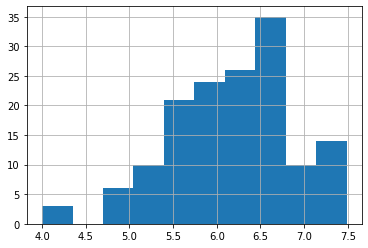

In [142]:
invest_covidPe['log_gastos'] = invest_covidPe['gastos'].apply(np.log10)
invest_covidPe[invest_covidPe['log_gastos'] > 0]['log_gastos'].hist()
invest_covidPe[(invest_covidPe['log_gastos'] > 0)].describe(include=['float64'])

#### **Testes de Hipótese** 

Teste de Shapiro-Wilk para a checar se a distribuição de gastos é normalizada

In [185]:
# Hipótese nula: Os gastos em saúde é normalmente distribuído.
from scipy import stats
stats.shapiro(invest_covidPe['gastos'])

(0.6282327771186829, 7.681099079313296e-18)

t-Test

In [187]:
stats.ttest_rel(invest_covidPe['gastos'], invest_covidPe['log_gastos'])

Ttest_relResult(statistic=7.895696601726666, pvalue=5.975348886828321e-13)

> Em ambos os casos, os testes de hipótese com *```p-value```* abaixo do valor crítico evidenciam a possibilidade da hipótese nula ser contraditória.

> Os resultados então indicam que a distribuição de verba para a saúde durante o ano foi irregular.

#### Casos confirmados de covid-19

In [129]:
#Criando um campo que nos permita relacionar a quantidade de casos confirmados pela população estimada
covidPeCases['confirmados_por_populacao'] = covidPeCases['casos_confirmados']/covidPeCases['pop_estimada']
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,id,confirmados_por_populacao
id,,,,,,,
0,ARCOVERDE,4281,87,0.0203,74822.0,0,0.057216
1,BUÍQUE,1436,23,0.0160,58919.0,1,0.024372
2,CARUARU,17187,454,0.0264,365278.0,2,0.047052
3,GARANHUNS,7250,134,0.0185,140577.0,3,0.051573
4,JABOATÃO DOS GUARARAPES,19966,1095,0.0548,706867.0,4,0.028246
5,OLINDA,14581,635,0.0435,393115.0,5,0.037091
6,PAULISTA,7154,528,0.0738,334376.0,6,0.021395
7,PETROLINA,18239,209,0.0115,354317.0,7,0.051477
8,RECIFE,78117,3168,0.0406,1653461.0,8,0.047245


In [ ]:
covidPeCases.dtypes

Ajustando tipo e transformando valores para porcentagem a fim de facilitar a percepção das taxas

In [130]:
covidPeCases['pop_estimada'] = covidPeCases['pop_estimada'].astype('int64')
covidPeCases['taxa_mortalidade'] = covidPeCases['taxa_mortalidade'] * 100
covidPeCases['confirmados_por_populacao'] = (covidPeCases['confirmados_por_populacao'] * 100).round(2)
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,id,confirmados_por_populacao
id,,,,,,,
0,ARCOVERDE,4281,87,2.03,74822,0,5.72
1,BUÍQUE,1436,23,1.60,58919,1,2.44
2,CARUARU,17187,454,2.64,365278,2,4.71
3,GARANHUNS,7250,134,1.85,140577,3,5.16
4,JABOATÃO DOS GUARARAPES,19966,1095,5.48,706867,4,2.82
5,OLINDA,14581,635,4.35,393115,5,3.71
6,PAULISTA,7154,528,7.38,334376,6,2.14
7,PETROLINA,18239,209,1.15,354317,7,5.15
8,RECIFE,78117,3168,4.06,1653461,8,4.72


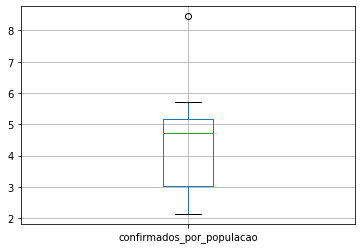

In [131]:
covidPeCases.boxplot(column=['confirmados_por_populacao'])

In [132]:
investimentoporcidade = invest_covidPe.groupby(by=['municipio']).sum()
investimentoporcidade

,tipo_favorecido,acao_orcamentaria,gastos,outlier,log_gastos
municipio,,,,,
0,7,0,6.829944e+06,7,40.437225
1,6,0,3.126474e+06,2,31.889402
2,16,8,4.256069e+07,8,100.168306
3,18,9,2.882383e+07,18,106.487756
4,20,10,8.632559e+07,0,129.650840
5,20,10,3.668715e+07,16,119.699312
6,9,0,1.064331e+07,7,52.674185
7,20,10,1.127178e+08,12,120.995926
8,22,12,2.742621e+08,-16,163.037351


##### **Junção dos dados de Gastos Públicos e Casos confirmados de Covid-19**

In [133]:
covidPeCases['gastos'] = investimentoporcidade['gastos'].values
covidPeCases['gastos_por_habitante'] = (covidPeCases['gastos'] / covidPeCases['pop_estimada']).round(2)
covidPeCases

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,id,confirmados_por_populacao,gastos,gastos_por_habitante
id,,,,,,,,,
0,ARCOVERDE,4281,87,2.03,74822,0,5.72,6.829944e+06,91.28
1,BUÍQUE,1436,23,1.60,58919,1,2.44,3.126474e+06,53.06
2,CARUARU,17187,454,2.64,365278,2,4.71,4.256069e+07,116.52
3,GARANHUNS,7250,134,1.85,140577,3,5.16,2.882383e+07,205.04
4,JABOATÃO DOS GUARARAPES,19966,1095,5.48,706867,4,2.82,8.632559e+07,122.12
5,OLINDA,14581,635,4.35,393115,5,3.71,3.668715e+07,93.32
6,PAULISTA,7154,528,7.38,334376,6,2.14,1.064331e+07,31.83
7,PETROLINA,18239,209,1.15,354317,7,5.15,1.127178e+08,318.13
8,RECIFE,78117,3168,4.06,1653461,8,4.72,2.742621e+08,165.87


##### **Discretização dos gastos por habitante** 
> *Nível de gastos* :
1. Muito baixo
2. Baixo
3. Médio
4. Alto 
5. Muito alto

In [134]:
print('intervalos', pd.cut(covidPeCases['gastos_por_habitante'].values,5).categories)
covidPeCases['nivel_de_gastos'] = pd.cut(covidPeCases['gastos_por_habitante'].values,5).codes + 1
covidPeCases

intervalos IntervalIndex([(31.544, 89.09], (89.09, 146.35], (146.35, 203.61], (203.61, 260.87], (260.87, 318.13]],
              closed='right',
              dtype='interval[float64]')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,municipio,casos_confirmados,mortes_confirmadas,taxa_mortalidade,pop_estimada,id,confirmados_por_populacao,gastos,gastos_por_habitante,nivel_de_gastos
id,,,,,,,,,,
0,ARCOVERDE,4281,87,2.03,74822,0,5.72,6.829944e+06,91.28,2
1,BUÍQUE,1436,23,1.60,58919,1,2.44,3.126474e+06,53.06,1
2,CARUARU,17187,454,2.64,365278,2,4.71,4.256069e+07,116.52,2
3,GARANHUNS,7250,134,1.85,140577,3,5.16,2.882383e+07,205.04,4
4,JABOATÃO DOS GUARARAPES,19966,1095,5.48,706867,4,2.82,8.632559e+07,122.12,2
5,OLINDA,14581,635,4.35,393115,5,3.71,3.668715e+07,93.32,2
6,PAULISTA,7154,528,7.38,334376,6,2.14,1.064331e+07,31.83,1
7,PETROLINA,18239,209,1.15,354317,7,5.15,1.127178e+08,318.13,5
8,RECIFE,78117,3168,4.06,1653461,8,4.72,2.742621e+08,165.87,3


In [173]:
covidPeCases_corr = covidPeCases.drop(columns={'id', 'nivel_de_gastos'})
covidPeCases_corr = covidPeCases_corr.rename(columns={'casos_confirmados' : 'Casos Confirmados',
                                                      'mortes_confirmadas' : 'Mortes Confirmadas',
                                                      'taxa_mortalidade' : 'Taxa de Mortalidade',
                                                      'pop_estimada' : 'População',
                                                      'confirmados_por_populacao' : 'Confirmados por população',
                                                      'gastos' : 'Verba da Saúde',
                                                      'gastos_por_habitante' : 'Despesas por Habitante'                                                   
                                                      })

Text(0.5, 1.0, 'Spearman')

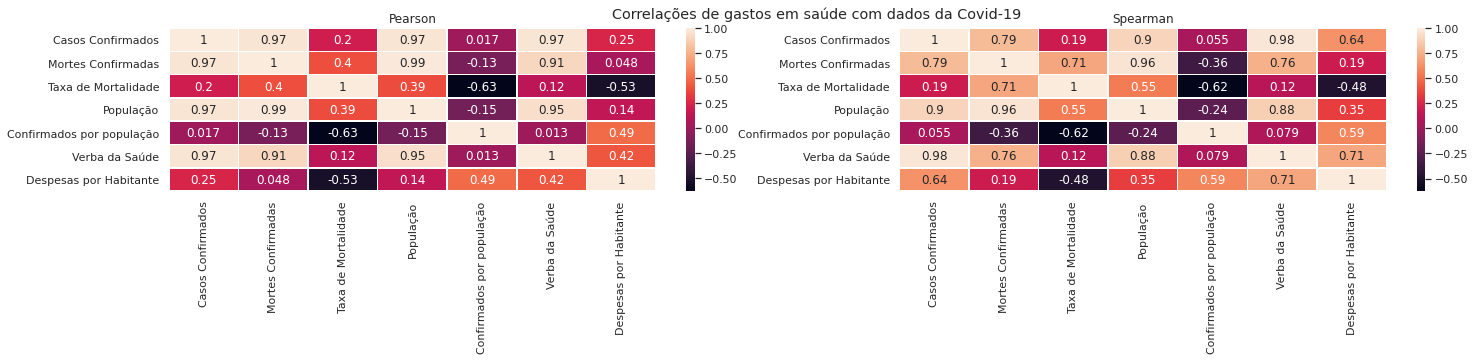

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(24,3))
fig.suptitle('Correlações de gastos em saúde com dados da Covid-19')
sns.heatmap(covidPeCases_corr.corr(method='pearson'), annot=True, linewidths=.5, ax=ax0)
ax0.set_title('Pearson')
sns.heatmap(covidPeCases_corr.corr(method='spearman'), annot=True, linewidths=.5, ax=ax1)
ax1.set_title('Spearman')

## Bônus: **Média móvel e Previsão de gastos para 2021**
  * Utilizaremos previsões em Séries Temporais
  * Recursos:
    - Pandas
    - Facebook Prophet

### **Conversão do Dataframe para trabalhar com distribuição temporal**
Conversão necessária para o desenvolvimento dos métodos de séries temporais

In [143]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('datetime64[ns]')
invest_covidPe.set_index('data_hora')
invest_covidPe.index = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 149 entries, 2020-03-10 to 2020-07-10
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          149 non-null    datetime64[ns]
 1   tipo_favorecido    149 non-null    int8          
 2   municipio          149 non-null    category      
 3   acao_orcamentaria  149 non-null    int8          
 4   gastos             149 non-null    float64       
 5   outlier            149 non-null    int64         
 6   log_gastos         149 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), int8(2)
memory usage: 6.6 KB


In [144]:
invest_covidPe.drop({'data_hora'},axis=1,inplace=True)
invest_covidPe.head(3)

,tipo_favorecido,municipio,acao_orcamentaria,gastos,outlier,log_gastos
data_hora,,,,,,
2020-03-10,1,8,1,60000.00,-1,4.778151
2020-04-10,1,3,1,1174944.27,1,6.070017
2020-04-10,1,7,1,4130446.89,1,6.615997


### **Visualização dos gastos em todo o estado**

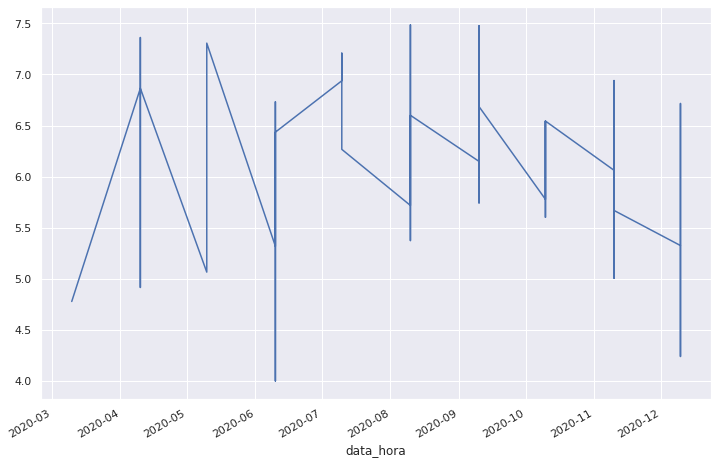

In [156]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(12, 8))
data = invest_covidPe.log_gastos
data.plot()

#### **Agregação de dados para visualização**

**Método**:
  * `resample`: *data aggregation*

**Amostragem**:
  * *Semanal* ('5D')
  * *Mensal* ('BM')
  * *Bimestre* ('91D')

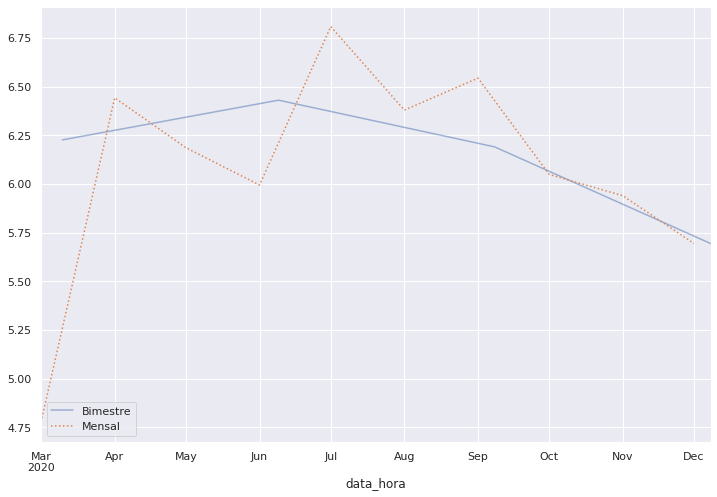

In [146]:
plt.figure(figsize=(12, 8))
data.resample('91D').mean().plot(alpha=0.5, style='-')
data.resample('BM').mean().plot(style=':')
plt.legend(['Bimestre', 'Mensal'], loc='lower left');

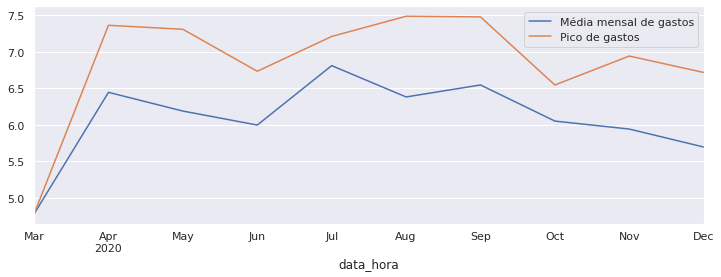

In [147]:
plt.figure(figsize=(12, 4))
data.resample('BM').mean().plot(label='Média mensal de gastos')
data.resample('BM').max().plot(label='Pico de gastos')
plt.legend()

### Janela deslizante

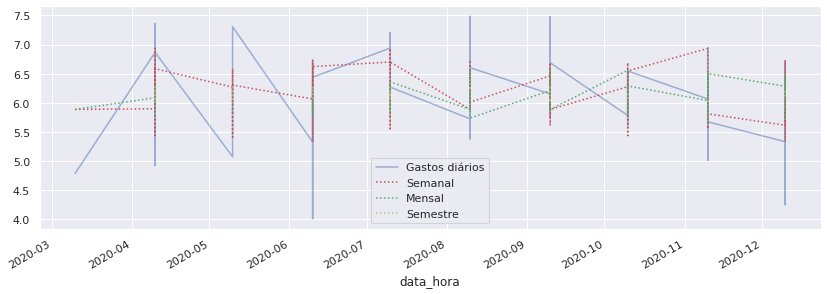

In [148]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
data.rolling(1).median().plot(label='Gastos diários' , alpha=.5)
(data.rolling(5)
 .median()
 .plot(label="Semanal", style='r:', alpha=1)
)
(data.rolling(30)
 .median()
 .plot(label="Mensal", style='g:', alpha=1)
)
(data.rolling(91)
 .median()
 .plot(label="Bimestre", style='y:', alpha=1)
)
plt.legend()

#### Previsões com Prophet

> Realizaremos previsões de gastos semanal, mensal e anual em relação ao estado de pernambuco com o agravamento da covid-19

> O conjunto histórico se dará com o todo o conjunto de dados de Março/2020 até Dezembro/2020

A intenção é avaliar se a previsão corresponde com os meses já passados de 2021 e com os próximos meses até o final do ano.

In [149]:
!pip install --quiet fbprophet

Para avaliação do melhor resultado para remoção de outliers, serão utilizados 
cópias dos dataframes gerados

In [151]:
from fbprophet import Prophet

prophet_df = data.reset_index()
prophet_df.columns = ["ds", "y"]
prophet_df.tail()

,ds,y
144,2020-07-10,6.698535
145,2020-04-10,6.864927
146,2020-10-10,6.544068
147,2020-07-10,6.938322
148,2020-07-10,6.267172


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


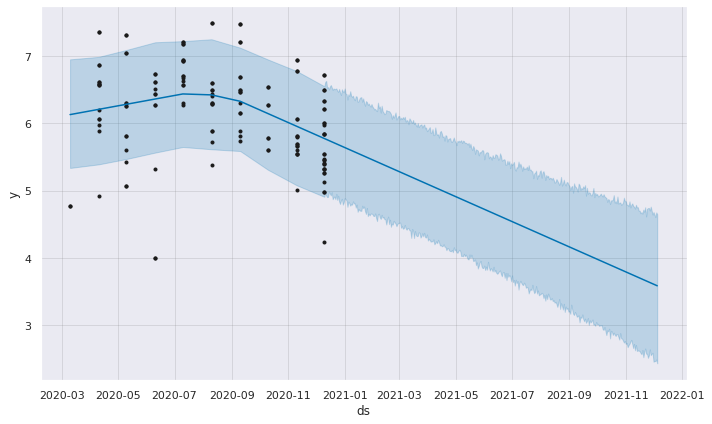

In [152]:
m = Prophet()
m.fit(prophet_df)
pred = m.predict(m.make_future_dataframe(periods=360))
m.plot(pred); # weird bug causes to plot twice, put ; in the end

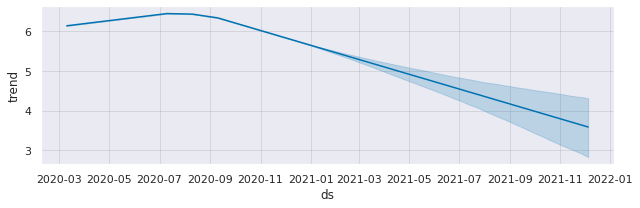

In [153]:
m.plot_components(pred);

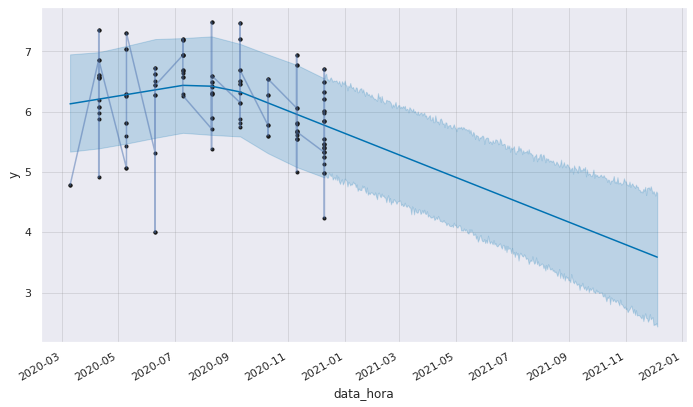

In [154]:
m.plot(pred); # weird bug causes to plot twice, put ; in the end
data.plot(label='Gastos (em milhões)', alpha=.5)